In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pymatgen.ext.matproj import MPRester

In [26]:
hbar = 1.054571817e-34 
k_B = 1.380649e-23     
N_A = 6.02214076e23     
R = N_A * k_B           

In [27]:
def get_heat_capacity_from_dos(dos, temperatures):
    energies = dos.frequencies * 1e12 * 2 * np.pi  # THz → rad/s
    densities = dos.densities.sum(axis=0)          # total DOS
    cv_list = []

    for T in temperatures:
        x = (hbar * energies) / (k_B * T)
        f = (x**2) * np.exp(x) / (np.exp(x) - 1)**2
        integrand = f * densities
        integral = np.trapz(integrand, energies)
        cv = 3 * N_A * k_B * integral
        cv_list.append(cv)

    return np.array(cv_list)

In [28]:
API_KEY = "V3MXH2I0Y7QlIPA7DnKaEb6MbSeygSrs"  # Remplacer par ta clé personnelle
mp_id = "mp-22990"  # Exemple : Si

with MPRester(API_KEY) as mpr:
    dos = mpr.get_phonon_dos_by_material_id(mp_id)

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
T_range = np.linspace(5, 1000, 300)
cv_exp = get_heat_capacity_from_dos(dos, T_range)


In [30]:
def cv_einstein(T, theta_E):
    x = theta_E / T
    return 3 * R * (x**2 * np.exp(x)) / (np.exp(x) - 1)**2

In [31]:
def cv_debye(T, theta_D):
    def debye_integral(x):
        return (x**4 * np.exp(x)) / (np.exp(x) - 1)**2

    C = []
    for t in T:
        if t == 0:
            C.append(0)
            continue
        x_D = theta_D / t
        x_vals = np.linspace(1e-5, x_D, 500)
        integral = np.trapz([debye_integral(x) for x in x_vals], x_vals)
        C.append(9 * R * (t / theta_D)**3 * integral)
    return np.array(C)


In [33]:
def fit_model(model_func, T, cv_exp):
    def loss(theta):
        return np.sum((cv_exp - model_func(T, theta[0]))**2)
    result = minimize(loss, x0=[300])
    return result.x[0]

theta_E_opt = fit_model(cv_einstein, T_range, cv_exp)
theta_D_opt = fit_model(cv_debye, T_range, cv_exp)

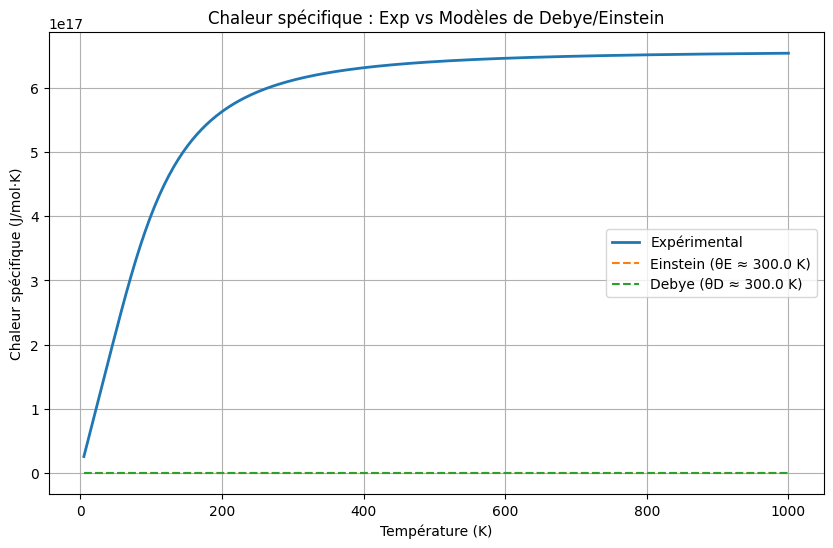

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(T_range, cv_exp, label="Expérimental", linewidth=2)
plt.plot(T_range, cv_einstein(T_range, theta_E_opt), '--', label=f"Einstein (θE ≈ {theta_E_opt:.1f} K)")
plt.plot(T_range, cv_debye(T_range, theta_D_opt), '--', label=f"Debye (θD ≈ {theta_D_opt:.1f} K)")
plt.xlabel("Température (K)")
plt.ylabel("Chaleur spécifique (J/mol·K)")
plt.title("Chaleur spécifique : Exp vs Modèles de Debye/Einstein")
plt.legend()
plt.grid(True)
plt.show()

frequencies shape: (351,)
densities shape: (351,)


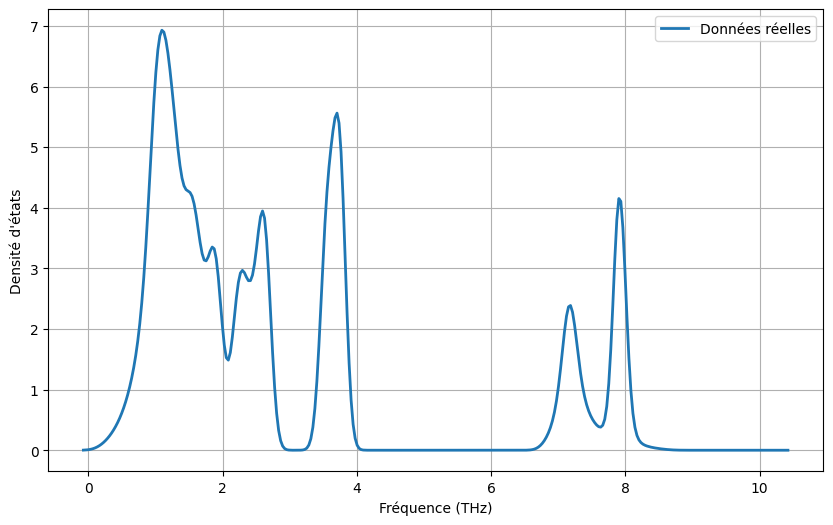

In [41]:
frequencies = dos.frequencies

densities = dos.densities
if isinstance(densities, np.ndarray):
    densities = np.squeeze(densities)
    if densities.ndim > 1:
        densities = np.sum(densities, axis=0)

print("frequencies shape:", frequencies.shape)
print("densities shape:", densities.shape)

plt.figure(figsize=(10,6))
plt.plot(frequencies, densities, label="Données réelles", linewidth=2)
plt.xlabel("Fréquence (THz)")
plt.ylabel("Densité d'états")
plt.legend()
plt.grid(True)
plt.show()
